In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import cmocean as cmo
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'; cfg = 'eventB_1'
grid, lon, lat, tem, sal, ssh, U, V, W, tmask = functions_plot.load_model_output(path, cfg)
utau, vtau = functions_plot.load_model_other(path, cfg)
depth_levels = grid['deptht'][:]

In [175]:
U.shape

(480, 30, 177, 237)

In [190]:
def get_speeds_transect(U_vel, V_vel, constant, p_min, p_max, time_inds, depth_ind, flag):    
    line = np.arange(p_min, p_max)
    len_line = len(line)-1
    
    # crop the velocities for the transect
    if flag == 'vertical_speed':
        U_vel = U_vel[:, :, p_min:p_max, constant-1:constant+1]
        V_vel = V_vel[:, :, p_min:p_max, constant-1:constant+1]
        speeds_all = np.zeros([len_line,len(time_inds)])
    elif flag == 'horizontal_speed':
        U_vel = U_vel[:, :, constant-1:constant+1, p_min:p_max]
        V_vel = V_vel[:, :, constant-1:constant+1, p_min:p_max]
        speeds_all = np.zeros([len(time_inds), len_line])

    # get the speeds along the transect at every time index and then store in a matrix
    for time_ind, m in zip(time_inds, np.arange(len(time_inds))):
        x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, depth_ind, time_ind, 1)
        for n in zip(np.arange(len_line)):
            if flag == 'vertical_speed':
                speeds_all[n, m] = speeds[n, :]
            elif flag == 'horizontal_speed':
                speeds_all[m, n] = speeds[:, n]
    
    return speeds_all, line


def get_X_vel_transect(X_vel, constant, p_min, p_max, time_inds, depth_ind, flag):    
    line = np.arange(p_min, p_max)
    len_line = len(line)

    if flag == 'vertical_vel':
        X_vel = X_vel[:, depth_ind, p_min:p_max, constant]
    elif flag == 'horizontal_vel':
        X_vel = X_vel[:, depth_ind, constant, p_min:p_max]
    
    X_all = np.zeros([len(time_inds), len_line])
    for time_ind, m in zip(time_inds, np.arange(len(time_inds))):
        X_all[m, :] = X_vel[time_ind, :]
    
    return X_all, line

In [193]:
def plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag):
    
    t1, t2 = 435, 447; time_inds = np.arange(480)
    
    if flag == 'vertical_speed':
        speed_plot, line = get_speeds_transect(U, V, constant, p_min, p_max, time_inds, depth_ind, flag)
        ns = np.arange(0, speed_plot.shape[0], interval)
    elif flag == 'horizontal_speed':
        speed_plot, line = get_speeds_transect(U, V, constant, p_min, p_max, time_inds, depth_ind, flag)
        ns = np.arange(0, speed_plot.shape[1], interval)
        
    #change this so that you can do U and V
    elif flag == 'vertical_vel' or flag == 'horizontal_vel':
        vel_plot, line = get_X_vel_transect(U, constant, p_min, p_max, time_inds, depth_ind, 'vertical_vel')
        ns = np.arange(0, vel_plot.shape[1], interval)
    
    fig = plt.figure(figsize=(20, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    fig.tight_layout(); fig.subplots_adjust(wspace=.1)
    
    len_line = len(line)-1
    constant_line = np.ones_like(line)*constant
    cms = np.linspace(0, 1, len_line)
    cs = [ cm.jet(x) for x in cms]
    
    c = ax1.contourf(bathy[:,:], cmap='Spectral_r')
    fig.colorbar(c, ax=ax1)
    if flag == 'vertical_speed':
        ax1.plot(constant_line, line, linewidth=5, c='k')
        for n in ns:
            ax2.plot(speed_plot[n,:], color = cs[n], label = str(p_min + n), linewidth=1.5)
    elif flag == 'horizontal_speed':
        ax1.plot(line, constant_line, linewidth=5, c='k')
        for n in ns:
            ax2.plot(speed_plot[:,n], color = cs[n], label = str(p_min + n), linewidth=1.5)
    elif flag == 'vertical_vel':
        ax1.plot(constant_line, line, linewidth=5, c='k')
        for n in ns:
            ax2.plot(vel_plot[:,n], color = cs[n], label = str(p_min + n), linewidth=1.5)
    elif flag == 'horizontal_vel':
        ax1.plot(line, constant_line, linewidth=5, c='k')
        for n in ns:
            ax2.plot(vel_plot[:,n], color = cs[n], label = str(p_min + n), linewidth=1.5)
    
    ax2.legend(ncol = 8)
    ax2.axvline(t1, c = 'k', linewidth=2)
    ax2.axvline(t2, c = 'k', linewidth=2)
    ax2.set_ylim([0,0.08]); ax2.set_xlim([0,480]); ax2.set_ylabel('speed across transect')
    ax2.set_title('Speeds along the transect [depth ' + str(int(depth_levels[depth_ind]))+' m]', fontsize=16)
    print('period [hrs]: ', t2-t1)
    return fig

# Speeds from all angles

period [hrs]:  12


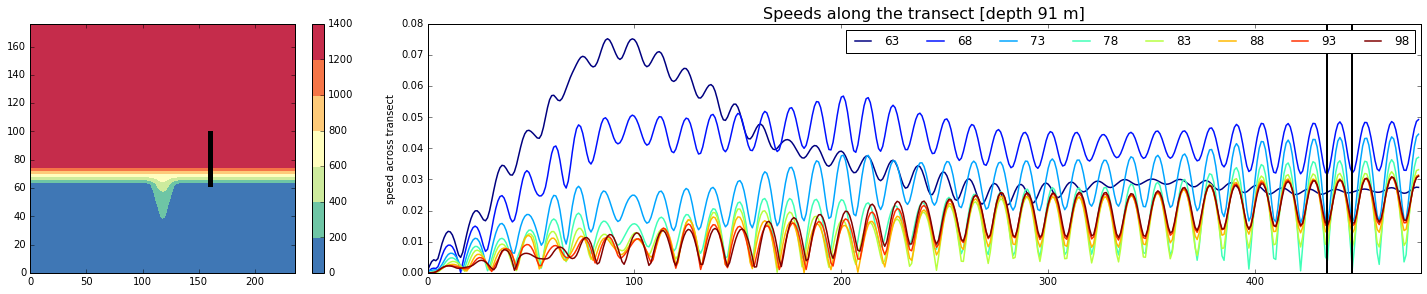

In [194]:
constant, p_min, p_max, depth_ind, interval, flag = 160, 63, 100, 7, 5, 'vertical_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


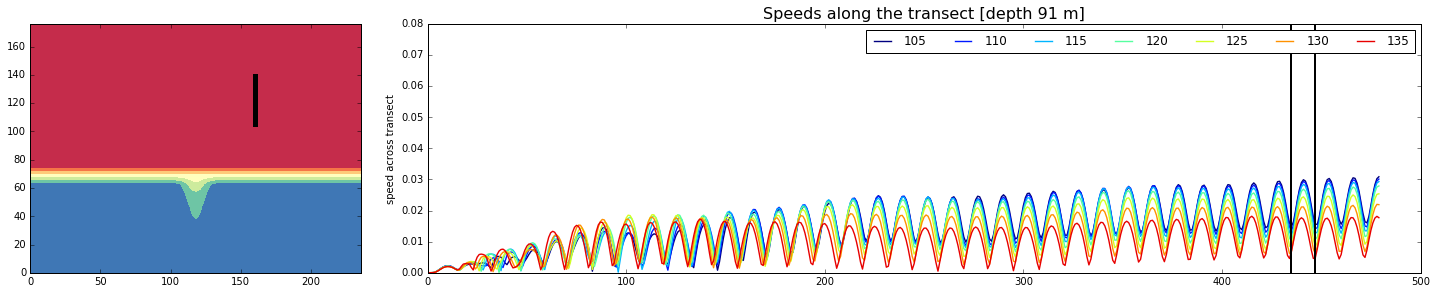

In [45]:
constant, p_min, p_max, depth_ind, interval, flag = 160, 105, 140, 7, 5, 'vertical_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


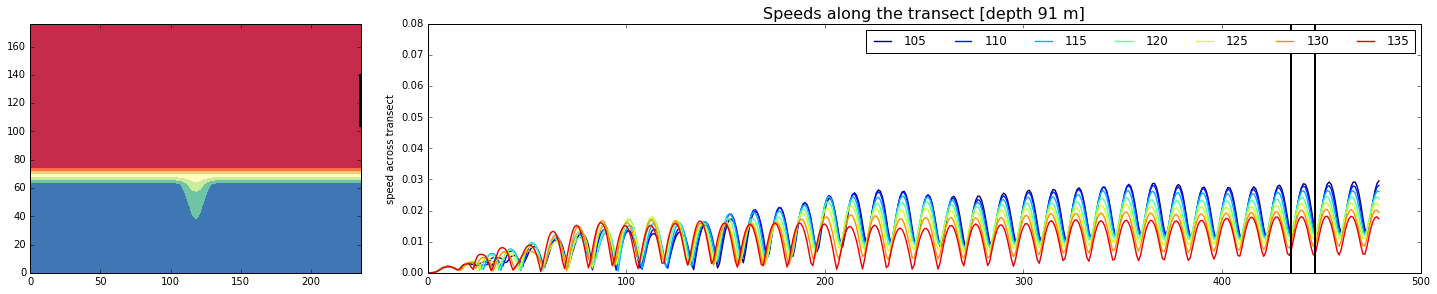

In [46]:
constant, p_min, p_max, depth_ind, interval, flag = 236, 105, 140, 7, 5, 'vertical_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


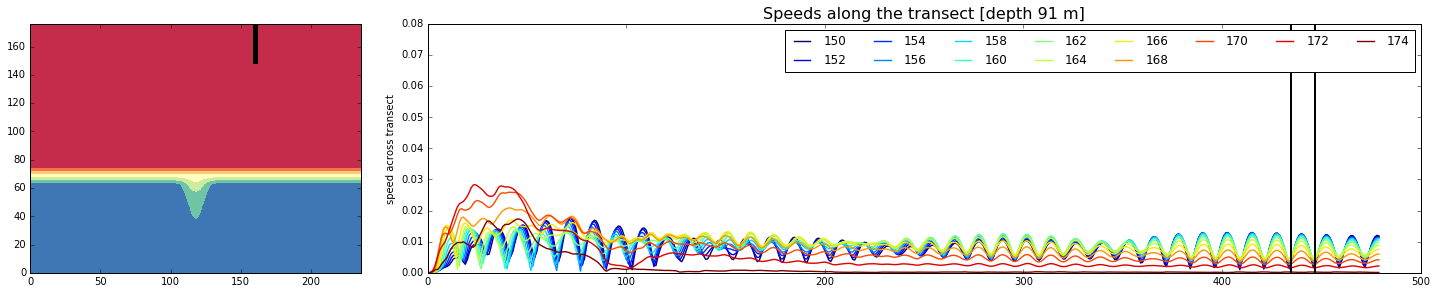

In [47]:
constant, p_min, p_max, depth_ind, interval, flag = 160, 150, 176, 7, 2, 'vertical_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


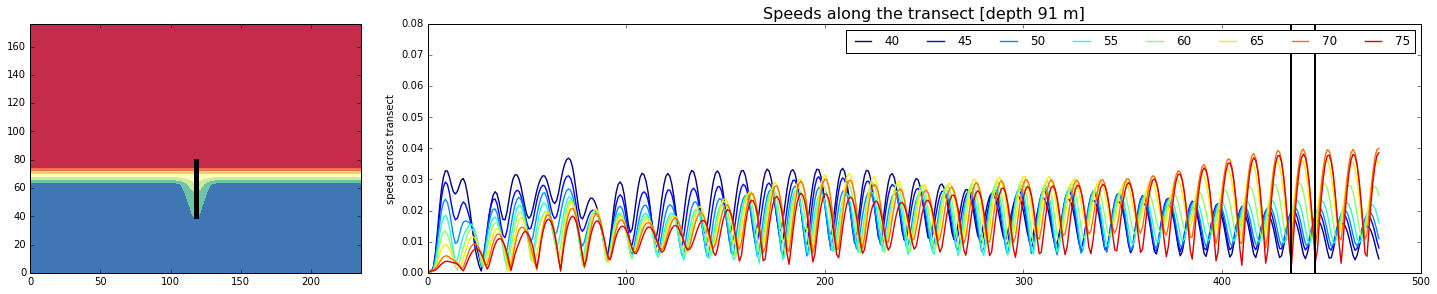

In [48]:
constant, p_min, p_max, depth_ind, interval, flag = 118, 40, 80, 7, 5, 'vertical_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


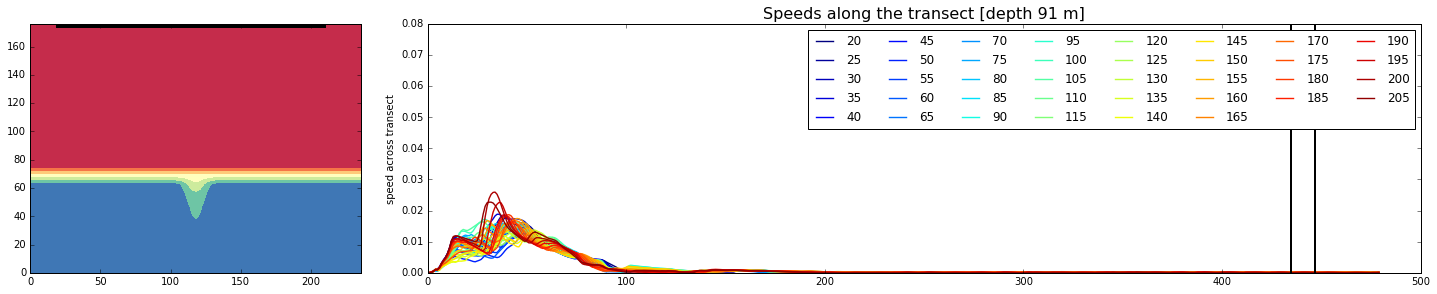

In [49]:
constant, p_min, p_max, depth_ind, interval, flag = 175, 20, 210, 7, 5, 'horizontal_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


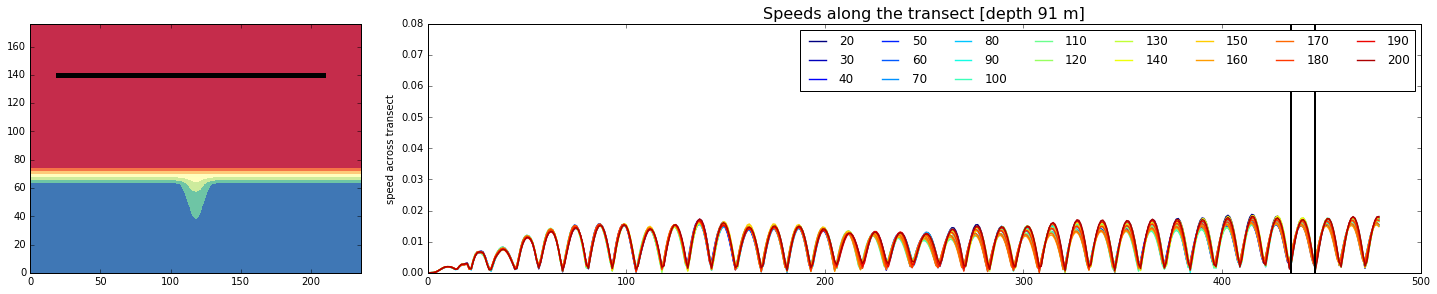

In [50]:
constant, p_min, p_max, depth_ind, interval, flag = 140, 20, 210, 7, 10, 'horizontal_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


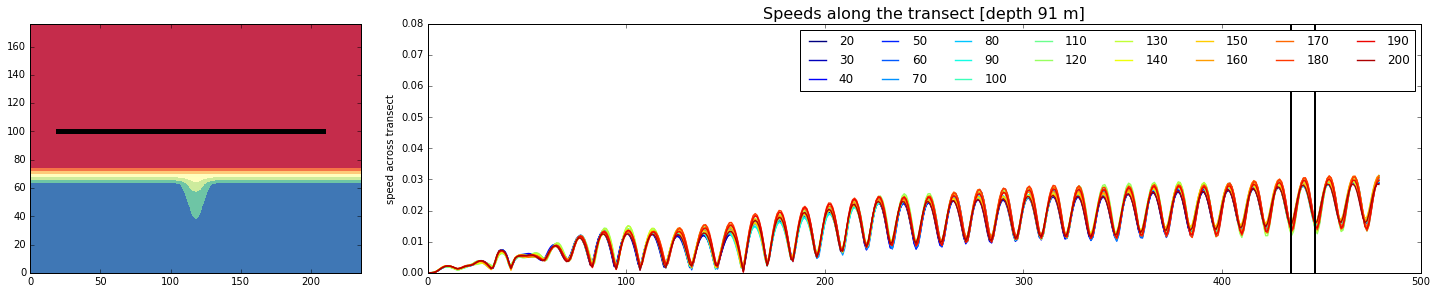

In [51]:
constant, p_min, p_max, depth_ind, interval, flag = 100, 20, 210, 7, 10, 'horizontal_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


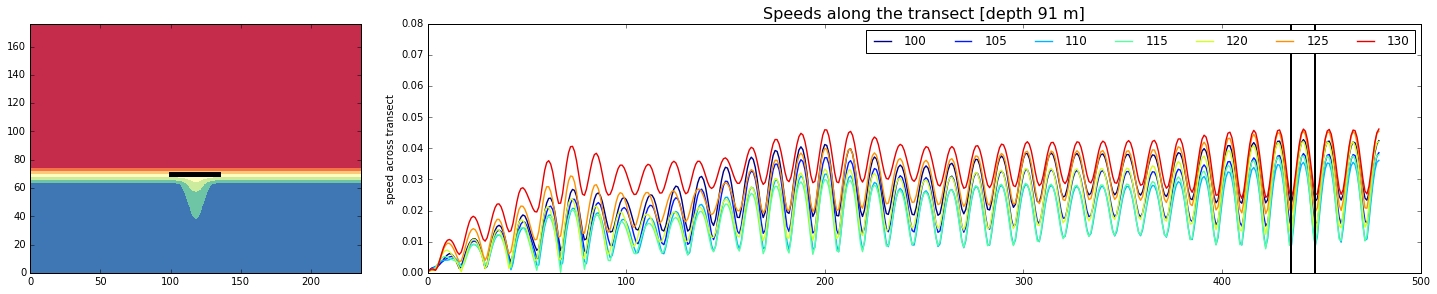

In [52]:
constant, p_min, p_max, depth_ind, interval, flag = 70, 100, 135, 7, 5, 'horizontal_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


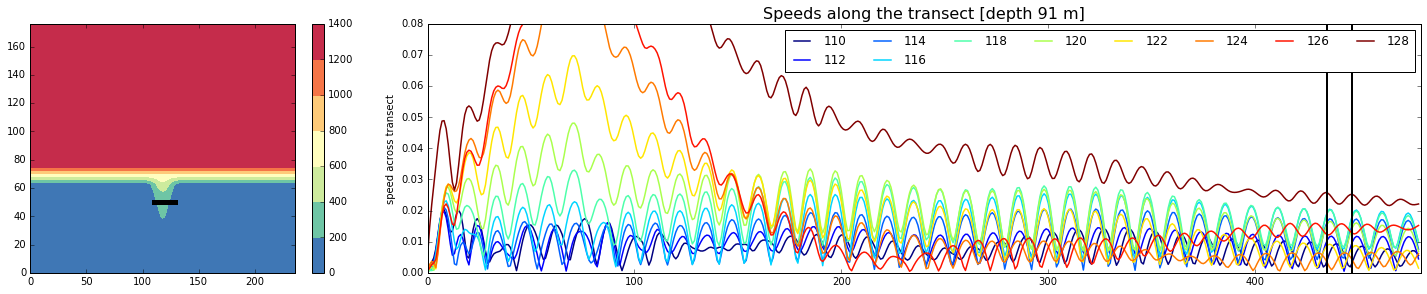

In [195]:
constant, p_min, p_max, depth_ind, interval, flag = 50, 110, 130, 7, 2, 'horizontal_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

# Speeds along NS transect for varying depths

period [hrs]:  12


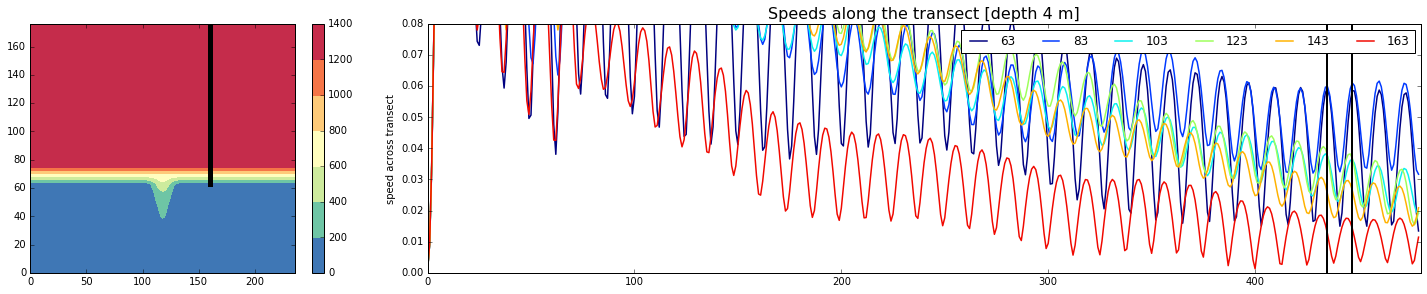

In [197]:
constant, p_min, p_max, depth_ind, interval, flag = 160, 63, 176, 0, 20, 'vertical_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


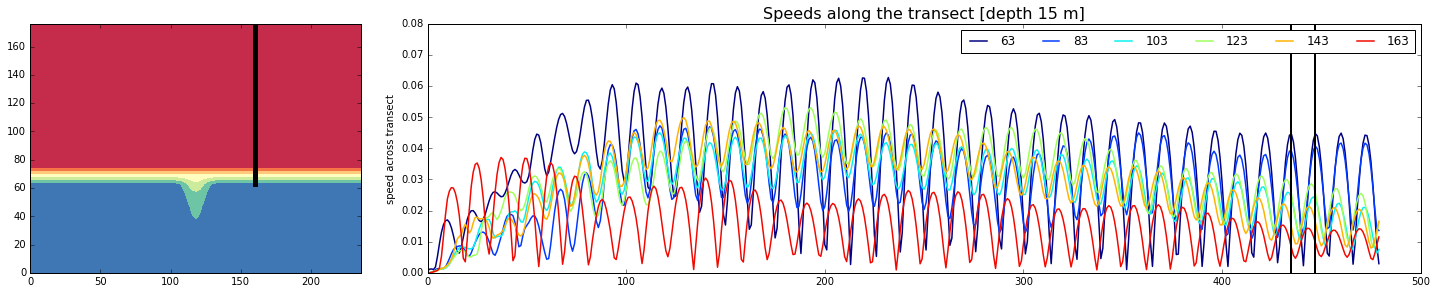

In [86]:
fig = plot_speed_evolution(constant, p_min, p_max, 1, interval, flag)

period [hrs]:  12


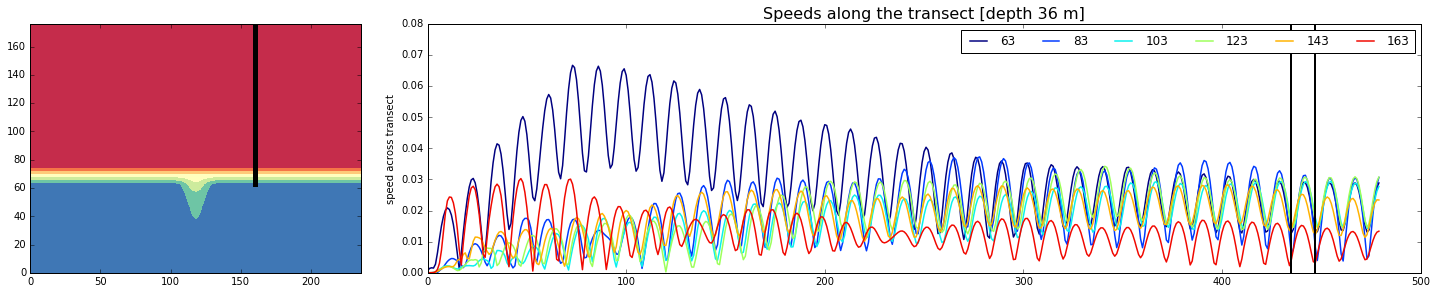

In [107]:
fig = plot_speed_evolution(constant, p_min, p_max, 3, interval, flag)

period [hrs]:  12


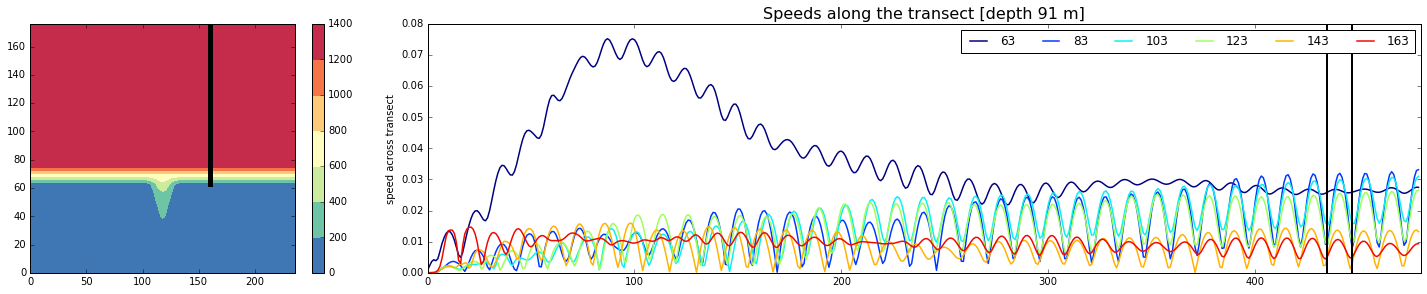

In [198]:
fig = plot_speed_evolution(constant, p_min, p_max, 7, interval, flag)

period [hrs]:  12


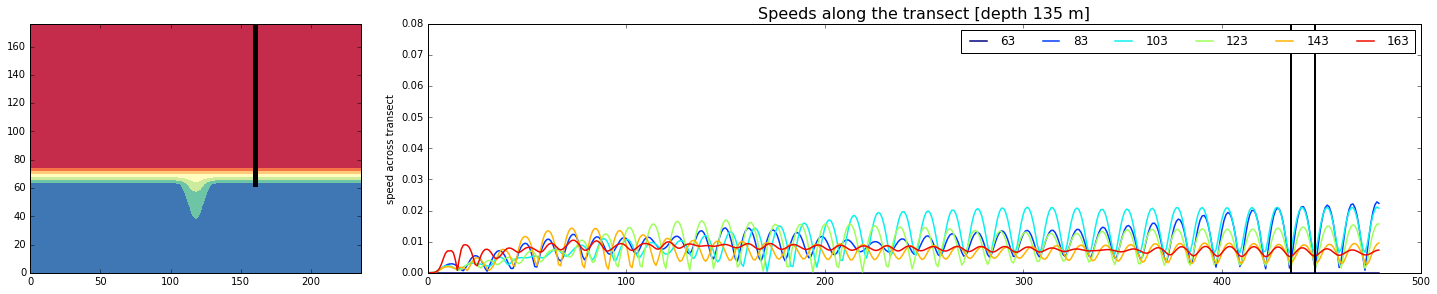

In [101]:
fig = plot_speed_evolution(constant, p_min, p_max, 9, interval, flag)

period [hrs]:  12


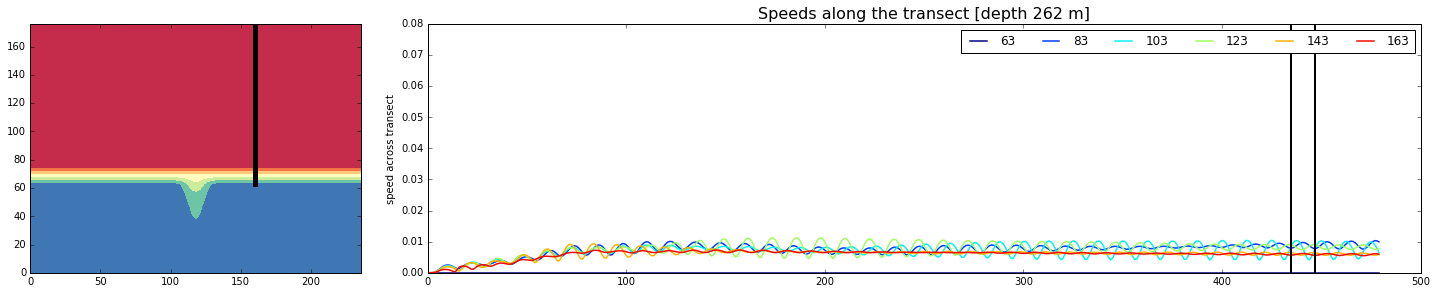

In [80]:
fig = plot_speed_evolution(constant, p_min, p_max, 12, interval, flag)

# Speeds along EW transect for varying depths

period [hrs]:  12


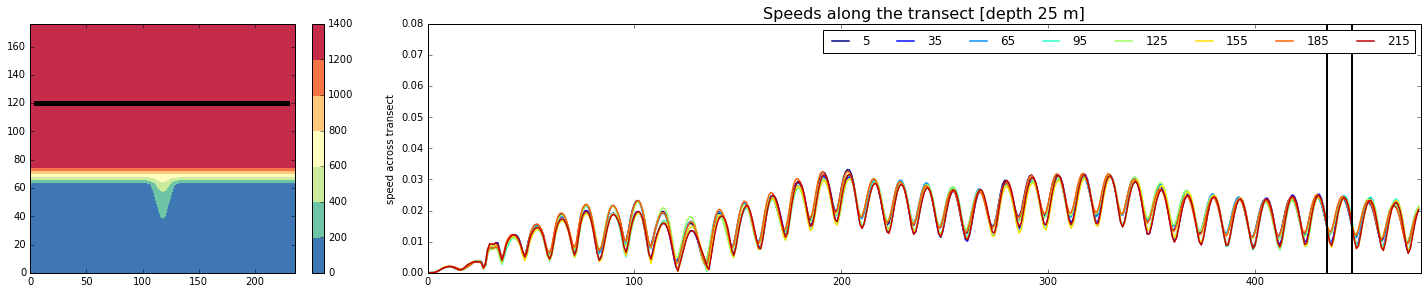

In [169]:
constant, p_min, p_max, depth_ind, interval, flag = 120, 5, 230, 2, 30, 'horizontal_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


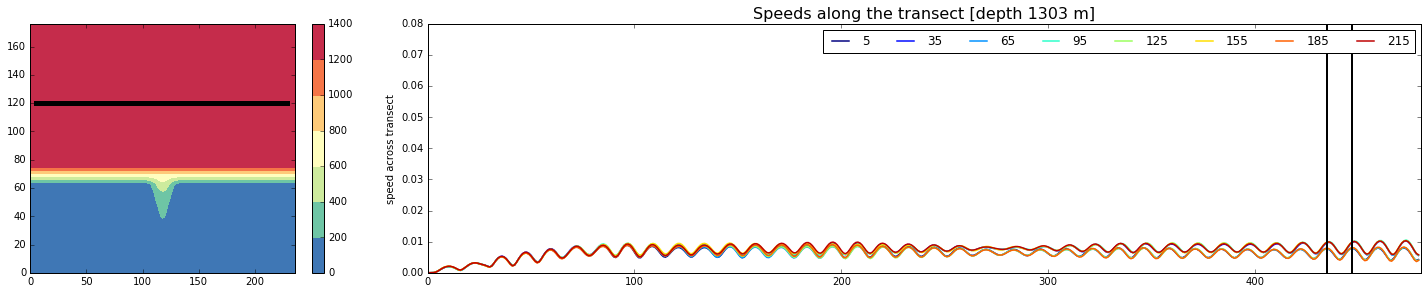

In [170]:
constant, p_min, p_max, depth_ind, interval, flag = 120, 5, 230, 19, 30, 'horizontal_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


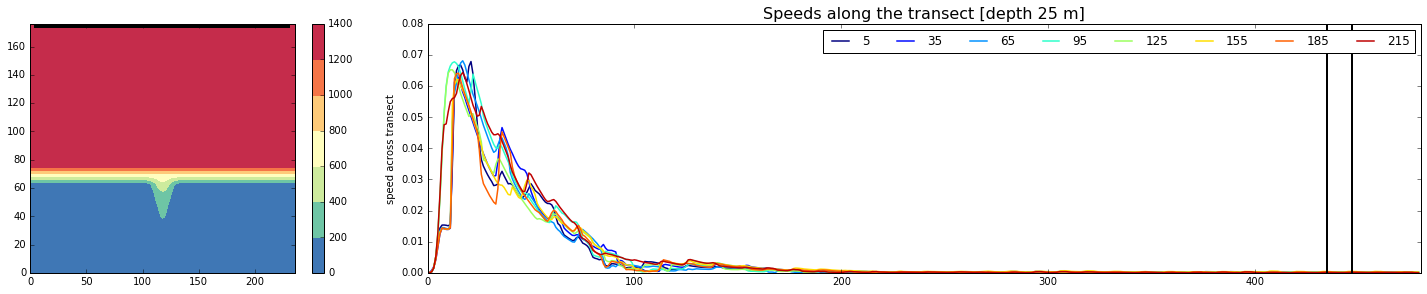

In [171]:
constant, p_min, p_max, depth_ind, interval, flag = 175, 5, 230, 2, 30, 'horizontal_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


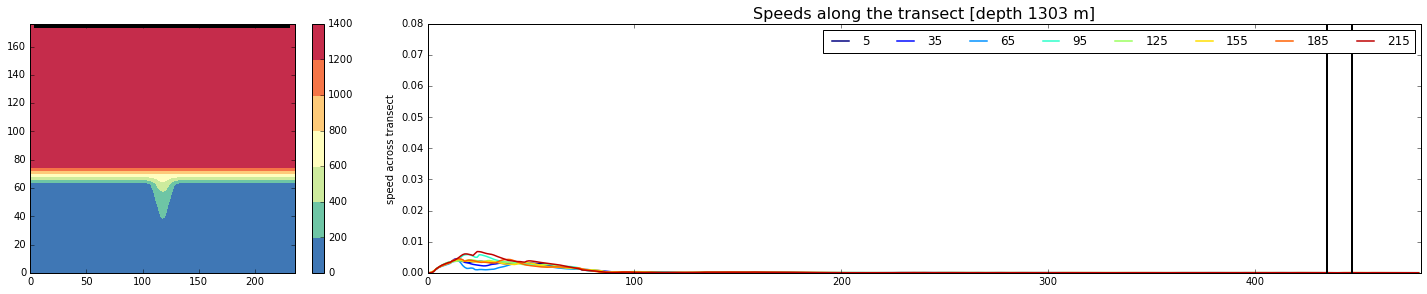

In [172]:
constant, p_min, p_max, depth_ind, interval, flag = 175, 5, 230, 19, 30, 'horizontal_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


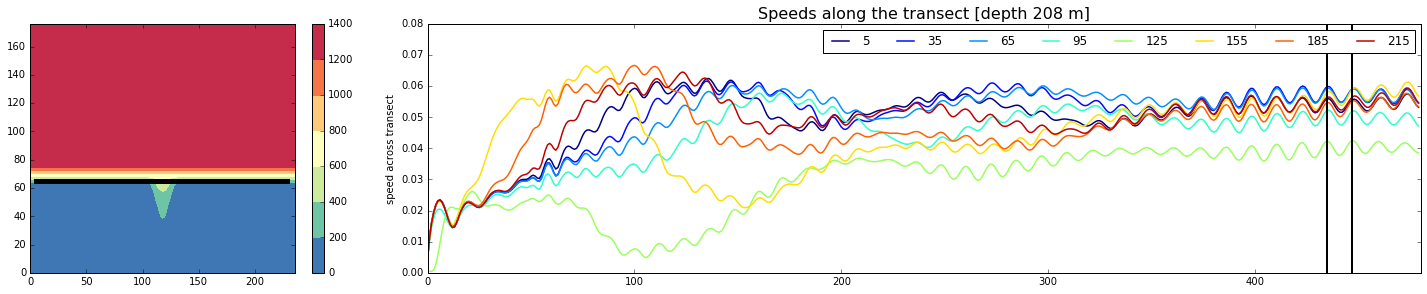

In [173]:
# the chosen depth is the closest to the bathymetry along the transect
constant, p_min, p_max, depth_ind, interval, flag = 65, 5, 230, 11, 30, 'horizontal_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)

period [hrs]:  12


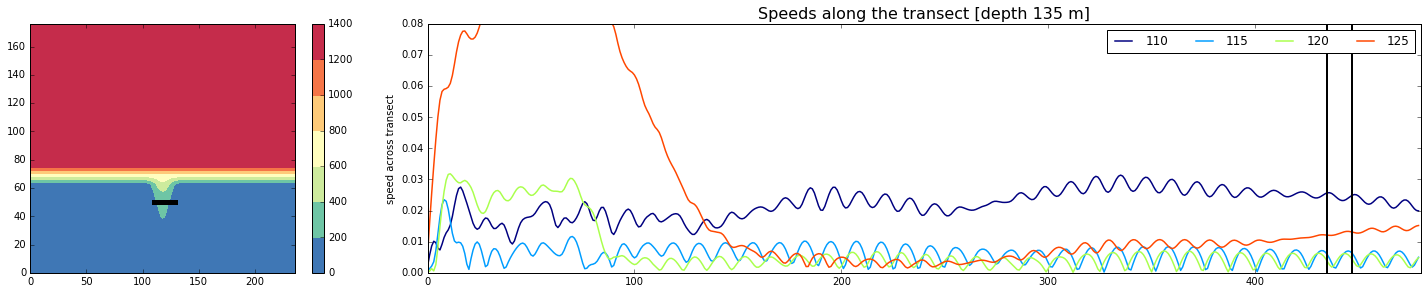

In [199]:
# the chosen depth is the closest to the bathymetry along the transect
constant, p_min, p_max, depth_ind, interval, flag = 50, 110, 130, 9, 5, 'horizontal_speed'
fig = plot_speed_evolution(constant, p_min, p_max, depth_ind, interval, flag)